In [1]:
%%time
### MUST USE GUDHI VERSION >= 3.3

#import python libraries 
import numpy as np     
import pandas as pd    
import timeit
import gudhi as gd
import cv2
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
#import scipy.io as sio
import warnings
import pickle

#plotting libraries
import matplotlib.pyplot as plt   
import seaborn as sns 

#TDA libraries (ripser, gudhi, persim)
from ripser import ripser
from persim import plot_diagrams, bottleneck, bottleneck_matching, sliced_wasserstein, wasserstein_matching

import sys, importlib

start_time_all = timeit.default_timer()

Wall time: 1.78 s


In [2]:
from sklearn import metrics
from scipy import optimize
import warnings

# For q = np.inf
# For q = 2, change chebychev to euclidean and don't divide by sqrt(2) for S and T
def wasserstein(dgm1, dgm2, matching=False, p = 2):
    """
    Perform the Wasserstein distance matching between persistence diagrams.
    Assumes first two columns of dgm1 and dgm2 are the coordinates of the persistence
    points, but allows for other coordinate columns (which are ignored in
    diagonal matching).

    See the `distances` notebook for an example of how to use this.

    Parameters
    ------------

    dgm1: Mx(>=2) 
        array of birth/death pairs for PD 1
    dgm2: Nx(>=2) 
        array of birth/death pairs for PD 2
    matching: bool, default False
        if True, return matching information and cross-similarity matrix

    Returns 
    ---------

    d: float
        Wasserstein distance between dgm1 and dgm2
    (matching, D): Only returns if `matching=True`
        (tuples of matched indices, (N+M)x(N+M) cross-similarity matrix)

    """

    S = np.array(dgm1)
    M = min(S.shape[0], S.size)
    if S.size > 0:
        S = S[np.isfinite(S[:, 1]), :]
        if S.shape[0] < M:
            warnings.warn(
                "dgm1 has points with non-finite death times;"+
                "ignoring those points"
            )
            M = S.shape[0]
    T = np.array(dgm2)
    N = min(T.shape[0], T.size)
    if T.size > 0:
        T = T[np.isfinite(T[:, 1]), :]
        if T.shape[0] < N:
            warnings.warn(
                "dgm2 has points with non-finite death times;"+
                "ignoring those points"
            )
            N = T.shape[0]

    if M == 0:
        S = np.array([[0, 0]])
        M = 1
    if N == 0:
        T = np.array([[0, 0]])
        N = 1
    # Compute CSM between S and dgm2, including points on diagonal
    DUL = metrics.pairwise.pairwise_distances(S, T, metric="chebyshev")

    # Put diagonal elements into the matrix
    # Rotate the diagrams to make it easy to find the straight line
    # distance to the diagonal
    cp = np.cos(np.pi/4)
    sp = np.sin(np.pi/4)
    R = np.array([[cp, -sp], [sp, cp]])
    S = S[:, 0:2].dot(R)/np.sqrt(2)
    T = T[:, 0:2].dot(R)/np.sqrt(2)
    D = np.zeros((M+N, M+N))
    np.fill_diagonal(D, 0)
    D[0:M, 0:N] = DUL
    UR = np.inf*np.ones((M, M))
    np.fill_diagonal(UR, S[:, 1])
    D[0:M, N:N+M] = UR
    UL = np.inf*np.ones((N, N))
    np.fill_diagonal(UL, T[:, 1])
    D[M:N+M, 0:N] = UL
    
    D=D**p
    

    # Step 2: Run the hungarian algorithm
    matchi, matchj = optimize.linear_sum_assignment(D)
    matchdist = np.sum(D[matchi, matchj])
    matchdist = matchdist**(1/p)

    if matching:
        matchidx = [(i, j) for i, j in zip(matchi, matchj)]
        ret = np.zeros((len(matchidx), 3))
        ret[:, 0:2] = np.array(matchidx)
        ret[:, 2] = D[matchi, matchj]
        # Indicate diagonally matched points
        ret[ret[:, 0] >= M, 0] = -1
        ret[ret[:, 1] >= N, 1] = -1
        # Exclude diagonal to diagonal
        ret = ret[ret[:, 0] + ret[:, 1] != -2, :] 
        return matchdist, ret

    return matchdist

In [3]:
def dist_matrix(xyz_frame, modif = None, indices=None):  
    '''
    This function creates a distance matrix from the point cloud data.
    (Note: zeroing methods only meant for MEDYAN 3D filament data)
    For pairwise neighbor zeroing, the distance between neighboring monomers will be set to 0.
    For whole filament zeroing, then all monomers on a filament will be set to distance 0 from each other.
    Parameters:
    1. xyz_frame: pandas dataFrame of xyz-coordinates of beads
    2. modif: specify modifications to distance matrix. None, pair (use modified distance matrix, zeros by pair), 
        whole (use modified distance matrix, zeros by filament). If invalid input, defaults to None
    3. indices: pandas series of bead indices (needed for neighbor modifications)
    Returns:
    distance matrix with modifications (if specified)

    '''
    #Exceptions for parameters
    if(not isinstance(xyz_frame, pd.DataFrame)):
        raise Exception("xyz_frame must be a Pandas DataFrame of point cloud data. ")
    if((modif == 'pair' or modif =='whole') and indices is None):
        raise Exception("Must give indices array if modifying the matrix by index.")
    
    # Creating a square, pairwise distance matrix out of the cleaned data
    distMat = squareform(pdist(xyz_frame))  
    
    #pairwise neighbor zeroing
    if(modif == 'pair'): #parameter of whether or not to zero out the neighbors
         
        #iterate over column of beads and check previous/next bead to see if neighbor
        for i in range(0, xyz_frame.shape[0]):
            #set distance to previous bead as 0 if neighbor
            if(i>0 and indices[i]==indices[i-1]):
                distMat[i][i-1] = 0
                distMat[i-1][i] = 0
                
    #whole filament zeroing
    elif(modif =='whole'):
        k = 0 #k is the first bead of a filament
        number_of_beads = xyz_frame.shape[0]
        
        while(k < number_of_beads): 
                current_fil_index = indices[k] #save current filament index
                j=k+1 #j traverses the following bead
                
                while(j<number_of_beads): #if there are still beads left to check 
                    if(indices[j]==current_fil_index): #check if j is part of k's filament
                        j=j+1 #onward to next bead
                    else:
                        # j-1 is endpoint of filament
                        distMat[k:j, k:j] = 0 # 0 out all beads on same filament(a square range of distMat)
                        k = j #k becomes first bead on next filament
                        break #repeat over next filament
                
                #break out of entire loop if last bead
                if(j >= number_of_beads):
                    break                   
    
    return distMat

In [4]:
def m_births_deaths(time, allx, ally):
    '''This function calculates the birth-death pairs at a given point in time.
    Works with both 2D and 3D data
    Parameters:
    1. time
    Returns:
    dataFrame m_birth_death s.t. m_birth_death[0] holds births, m_birth_death[1] holds deaths
    '''
    # ie. select (TIME) column of dataframes to get x,y for beads at TIME seconds
    img = to_img(time, allx, ally)
    st = level_set_flooding(img, iter_num=100)
    pairs = st.persistence()
    pairs = list(set(pairs))
    m = []
    for i in pairs:
        if i[0] == 1:
            m.append(list(i[1]))

    m_birth_death = pd.DataFrame(m)
    return m_birth_death

In [5]:
def nanvalue(c,triangle_pts,index):
    '''
    If valid index(c) given, returns the birth/x (index = 0) or death/y (index 1); else give NaN
    '''
    if np.isnan(c):
        x = np.nan
    else:
        x = triangle_pts[index][c] 
    return x

In [6]:
# Calculate persistence diagram features for each time
def calculate_all_persistence_diagrams(allx, ally):
    '''
        This function calculates persistence diagrams for every point in time in the sample data
        Parameters:
        1. dist_mode: specify how/whether to use distance matrix.
        None means do not use a distance matrix (use xyz point cloud directly),
        distance (use distance matrix of point cloud), pair (use modified distance matrix, zeros by pair),
        whole (use modified distance matrix, zeros by filament). Note: None and distance should have the same results
        Returns:
        list of {birth-death pair data frames} indexed by time

    '''
    list_bd = []

    for time in range(allx.shape[1]): #iterate over columns (each column is beads at time)
        m_birth_death = m_births_deaths(time, allx, ally) #         sorts in persistence order
        m_birth_death['Persistence'] =  m_birth_death[1] - m_birth_death[0]
        m_birth_death = m_birth_death.sort_values(by=['Persistence'], ascending=False)
        m_birth_death = m_birth_death.reset_index(drop=True)
        m_birth_death = m_birth_death.drop(columns=['Persistence'])
        list_bd.append(m_birth_death)
    return list_bd

In [7]:
def connection_btwn_two(ptsA,ptsB, cont_diff=99999): 
    '''
    Default matching is greedy
    Parameters:
    1. ptsA: a dataframe of bd-pairs. birth radii in column 0, death radii in column 1
    2. pts B: ptsA, for another time frame
    3. cont_diff: Continuity difference, maximum distance we should still attach two triangles
    Returns:
    pair_mat, an array of indexes representing matchings between bd-pairs in pts A and ptsB.
    Each row consists of the index of a bd-pair in ptsA (column 0), and the index of its nearest corresponding
    bd-pair in ptsB (column 1).
    - Indexes are based on the original index of the bd-pair within ptsA/ptsB.
    - Dimensions of pair-mat should be (number of matches, including trivial matches) by 2
    - Pairs with NaN values such as (1, NaN) ( or (NaN, 5) ) indicate that the bd-pair of that index in pts A (or B)
      has no matching b-d pair in pts B (or A)
    
    '''
    # Making matrix with distance between all the points in each time step
    num_ptsA = len(ptsA.index)
    num_ptsB = len(ptsB.index)
    distance_mat = distance_matrix(ptsA.values,ptsB.values) #scipy spatial, b-d pairs in DF treated as points
    #on distance matrix, rows correspond to ptsA, columns to ptsB

    # Finding the closest points
    pairs_mat = []   

    # If there are no points in either time step, match up all points with NaN
    if distance_mat.shape[1] == 0:
        for i in range(0,num_ptsA):
            pair = (i,np.nan)
            pairs_mat.append(pair)
        pairs_mat = np.asarray(pairs_mat)
        return(pairs_mat)
    elif distance_mat.shape[0] == 0:
        for j in range(0,num_ptsB):
            pair = (np.nan,j)
            pairs_mat.append(pair)  
        pairs_mat = np.asarray(pairs_mat)
        return(pairs_mat)

    if num_ptsA < num_ptsB:

        # Iterate over the points in pts_A
        for i in range(0,num_ptsA):

            # min_dist is the minimum distance from i in the distance matrix
            # nanmin finds the minimum excluding NaN
            min_dist = np.nanmin(distance_mat[i,:])

            # If min_dist is less than cont_diff, the points will be assigned to a pair
            if min_dist < cont_diff:

                # closest_B will be the index of the point that had the lowest distance
                closest_B = np.nanargmin(distance_mat[i,:])

                # Set those segments of the distance matrix to NaN so they don't get erroneously paired with other points
                distance_mat[i,:] = np.nan
                distance_mat[:,closest_B] = np.nan
                pair = (i,closest_B)
                pairs_mat.append(pair)

            # If min_dist > cont_diff, the points are too far away to be considered continuous
            # so the point is matched with NaN
            else:
                distance_mat[i,:] = np.nan
                pair = (i,np.nan)
                pairs_mat.append(pair)

        #change from list of tuples to an array
        pairs_mat = np.asarray(pairs_mat)

        # Set the rest of the points to be matched with NaN
        for j in range(0,num_ptsB):
            if j not in pairs_mat[:,1]:
                pair = (np.nan,j)
                pairs_mat = np.vstack([pairs_mat,pair])    

    # In this case, num_ptsA >= num_ptsB, it does the same thing
    else: #if num_ptsA >= num_ptsB:
        for j in range(0,num_ptsB):
            min_dist = np.nanmin(distance_mat[:,j])
            if min_dist < cont_diff:
                closest_A = np.nanargmin(distance_mat[:,j])
                distance_mat[:,j] = np.nan
                distance_mat[closest_A,:] = np.nan
                pair = (closest_A,j)
                pairs_mat.append(pair)
            else:
                distance_mat[:,j] = np.nan
                pair = (np.nan,j)
                pairs_mat.append(pair)
        pairs_mat = np.asarray(pairs_mat)

        # Set the rest of the points to be matched with NaN
        for i in range(0,num_ptsA):
            if i not in pairs_mat[:,0]:
                pair = (i,np.nan)
                pairs_mat = np.vstack([pairs_mat,pair])

    return(pairs_mat)

In [8]:
def wasserstein_connection_btwn_two(ptsA,ptsB, p_order=2): 
        # Converts to numpy array because wasserstein_distance takes numpy arrays only
        ptsA = ptsA.to_numpy()
        ptsB=ptsB.to_numpy()
        
        cost, matchings = wasserstein(ptsA, ptsB, matching=True, p=p_order)
        matchings = matchings[:,:2] #get matchings only
        # Matchings gives the pairs that the Wasserstein distance generated

        # Wasserstein pairs put -1 if matched to the diagonal, not NaN, so we're fixing that here
        matchings = matchings.astype(np.float64) #needs to be float in order to have NaN
        for i in range(len(matchings)):
            for j in range(2):
                if (matchings[i,j] == -1):
                    matchings[i,j] = np.nan
                
        return matchings

In [9]:
def bottleneck_connection_btwn_two(ptsA, ptsB):
        # Converts to numpy array because bottleneck takes numpy arrays only
        ptsA = ptsA.to_numpy()
        ptsB = ptsB.to_numpy()
        
        bdist = bottleneck(ptsA,ptsB,matching=True)
        bottleneck_matches = bdist[1]
        sort_index = bottleneck_matches[:,2].argsort() #get indices of sorting rows in ascending distance order
        np.flip(sort_index) #descending indices
        bottleneck_matches = bottleneck_matches[sort_index] #sort matches based on proximity
        matchings = bottleneck_matches[:,:2] #get matchings only

        #Bottleneck pairs put -1 if matched to the diagonal, not NaN, so we're fixing that here
        matchings = matchings.astype(np.float64) #needs to be float in order to have NaN
        for i in range(len(matchings)):
            for j in range(2):
                if (matchings[i,j] == -1):
                    matchings[i,j] = np.nan
                
        return matchings

In [10]:
%%time
def initialize_connection_arrays(list_bd, match_two_PDs, **kwargs):
    '''
    This function initializes the l_mat, all_x_conn, and all_y_conn arrays using the first and second time steps
    (matches between first 2 persistence diagrams)
    Parameters:
    1. list_bd: list of birth-death data frames, get from calculate_all_persistence_diagrams
    2. match_two_PDs: function used to connect between two persistence diagrams
    3. **kwargs: q_order (Wasserstein), cont_diff (Greedy)
    Returns:
    tuple of l_mat array, all_x_conn array and all_y_conn array
    l_mat: Each row is a path of persistent diagram features. The columns represent the time/identify
    which persistence diagram, and the cell value is the index of the 1-D loop/feature within the PD.
    Subsequent features in a row match to the next feature identified by its index.
    all_x_conn, all_y_conn are the same shape l_mat, and contain the (x,y) values of the PD feature
    '''
    
    ## Get points for first time step 
    triangle_pointsA = list_bd[0] #DataFrame
    ## Get points for second time step 
    triangle_pointsB = list_bd[1] #DataFrame
        
    ## Set up connection matrices for the first two steps
    ab = match_two_PDs(triangle_pointsA,triangle_pointsB, **kwargs)
    # print(type(ab))
    #print(ab)
    l_mat = ab
    
    #initialize all_x_conn and all_y_conn arrays
    x_pairs = []
    y_pairs = []
    for k in range(0,len(ab)): 
        cA = ab[k,0]
        cB = ab[k,1]
        
        #!! check this
        # Checks to see if each point is NaN. If not, returns the index to be put into the pairs
        #x_pair is the birth value of pt from triangle_ptsA with the birth value of matching pt from triangle_ptsB
        x_pair = (nanvalue(cA,triangle_pointsA,0),nanvalue(cB,triangle_pointsB,0)) #x_pair = (triangle_pointsA[0][cA],triangle_pointsB[0][cB])
        y_pair = (nanvalue(cA,triangle_pointsA,1),nanvalue(cB,triangle_pointsB,1)) #y_pair = (triangle_pointsA[1][cA],triangle_pointsB[1][cB])
        x_pairs.append(x_pair)
        y_pairs.append(y_pair) 
        
    all_x_conn = np.asarray(x_pairs)
    all_y_conn = np.asarray(y_pairs)

    return (l_mat, all_x_conn, all_y_conn)

Wall time: 0 ns


In [11]:
%%time
# Connect all remaining steps through time
def extend_connection_arrays(list_bd, match_two_PDs, l_mat, all_x_conn, all_y_conn, **kwargs):
    '''
    This function returns the l_mat, all_x_conn, and all_y_conn arrays, which contain information on the paths
    of PD features, across all time steps
    (matches between persistent features of all persistence diagrams)
    Parameters:
    1. list_bd: list of birth-death data frames, get from calculate_all_persistence_diagrams
    2. match_two_PDs: function used to connect between two persistence diagrams
    3-5: l_mat, all_x_conn, and all_y_conn; as initialized by first 2 time steps in intialize_connection_arrays()
    6. **kwargs: q_order (Wasserstein), cont_diff (Greedy)
    Returns:
    tuple of l_mat array, all_x_conn array and all_y_conn array
    l_mat: Each row is a path of persistent diagram features. The columns represent the time/identify
    which persistence diagram, and the cell value is the index of the 1-D loop/feature within the PD.
    Subsequent features in a row match to the next feature identified by its index.
    all_x_conn, all_y_conn are the same shape l_mat, and contain the (x,y) values of the PD feature
    - dimensions: (number of paths, including trivial paths) by (number of time steps)
    '''
    for time in range(1,len(list_bd)-1):

        ## Get points for first time step 
        triangle_pointsB = list_bd[time]   
        ## Get points for second time step 
        triangle_pointsC = list_bd[time+1]

        ## Connections to be added
        bc = match_two_PDs(triangle_pointsB,triangle_pointsC, **kwargs)

        ## Sets up matrix for connections, indirectly handles death of orphans
        
        #create a NaN-filled column w as many rows as l_mat currently
        n_emp_row = np.full((len(l_mat),1), np.nan)
        
        # append NaN column to l_mat array
        l_mat = np.hstack((l_mat,n_emp_row)) 
        all_x_conn = np.hstack((all_x_conn,n_emp_row))
        all_y_conn = np.hstack((all_y_conn,n_emp_row))

        for p in range(0,len(bc)):
            #get the current index B (index of a PD feature)
            cB = bc[p,0]
            
            #get index, x, and y values of B's match C
            cC = bc[p,1]
            ptCx = nanvalue(cC,triangle_pointsC,0)
            ptCy = nanvalue(cC,triangle_pointsC,1)
            
            # Matches up all pairs
            #connect each index 'B' in bc with its counterpart in the previous l_mat column 
            #get 2nd to last column of l_mat, contains column of matches that need to be extended
            prev_l_mat_column = l_mat[:,-2] 
            
            if not np.isnan(cB):  #
                if cB in prev_l_mat_column: #checks if cB is present in the second to last row
                    posB_in_l_mat = int(np.where(prev_l_mat_column==cB)[0]) # find cB's pos in l_mat
                    #append the match C to the correct row
                    l_mat[posB_in_l_mat,-1] = cC
                    all_x_conn[posB_in_l_mat,-1] = ptCx
                    all_y_conn[posB_in_l_mat,-1] = ptCy

            else:  # Handles birth of orphans
                
                #create a NaN row of l_mat's width (all_x_conn and all_y_conn are the same size)
                orphan_row = np.full((1,l_mat.shape[1]), np.nan)
                
                #edit the last column of NaN row to hold orphan's value, and append to respective arrays
                #add row of [NaN NaN .... NaN (index)] to l_mat
                orphan_row[0, -1] = cC
                l_mat = np.vstack((l_mat,orphan_row))
                #add row of [NaN NaN .... NaN (x-value)] to all_x_conn
                orphan_row[0, -1] = ptCx
                all_x_conn = np.vstack((all_x_conn, orphan_row))
                #add row of [NaN NaN .... NaN (y-value)] to all_y_conn
                orphan_row[0, -1] = ptCy
                all_y_conn = np.vstack((all_y_conn,orphan_row))

    return (l_mat, all_x_conn, all_y_conn)

Wall time: 0 ns


In [12]:
def generate_connection_arrays(list_bd, wass=False, bott=False, **kwargs):
    '''
    Generate the numpy arrays of paths between PD features (indexes, x-coordinates, and y-coordinates)
    Parameters:
    1. list_bd: list of birth-death data frames, get from calculate_all_persistence_diagrams
    2. wass: If True, generate matchings using wasserstein distance
    3. bott: If True, generate matchings using bottleneck distance
    4. **kwargs: q_order (Wasserstein), cont_diff (Greedy)
    Returns:
    tuple of l_mat, all_x_conn, all_y_conn
    '''
    if wass and bott:
        raise Exception("Please specify Wasserstein or Bottleneck (cannot both be true)")
        
    #select which function/method (Greedy, Wasserstein, Bottleneck) to use for matchings
    if wass:
        connect_function = wasserstein_connection_btwn_two
    elif bott:
        connect_function = bottleneck_connection_btwn_two
    else:
        connect_function = connection_btwn_two
    
    #generate
    init_tuple = initialize_connection_arrays(list_bd, connect_function, **kwargs)     #returns (l_mat, all_x_conn, all_y_conn)
    complete_tuple = extend_connection_arrays(list_bd, connect_function, l_mat=init_tuple[0], all_x_conn=init_tuple[1], all_y_conn=init_tuple[2], **kwargs)
    
    return complete_tuple

In [13]:
def to_img(time, allx, ally):
    '''
    This function converts from x,y points of pixels to a dataframe containing the image
    '''
    matx = allx[time]
    maty = ally[time]

    coordinates = pd.concat([matx,maty], axis=1, sort=False)
    coordinates = coordinates.dropna()

    img = np.zeros((im_x, im_y))

    for i in range(len(coordinates) - 1):
        img[im_y - int(maty[i]) - 1, int(matx[i])] = 1

    return img

In [14]:
# Code from https://github.com/johnnardini/Angio_TDA ("Topological data analysis distinguishes parameter regimes in the Anderson-Chaplain model of angiogenesis" by John Nardini, Bernadette Stolz, Kevin Flores, Heather Harrington, and Helen Byrne)
def level_set_flooding(N,filename=None,iter_num=50):

    '''
    level_set_flooding

    inputs:
    N : Binary image
    iter_num : number of flooding events to compute

    output
    diag : Birth and death times for all topological features
    '''


    xm,ym = N.shape

    st = gd.SimplexTree()

    kernel = np.ones((3,3),np.uint8)
    N = cv2.dilate(N,kernel,iterations=1)

    for iterate in np.arange(iter_num):

        if iterate != 0:
            N = cv2.dilate(N,kernel,iterations=1)

        ## look for vertical neighbors
        vert_neighbors = np.logical_and(N[:-1,:]==1,N[1:,:]==1)
        a = np.where(vert_neighbors)
        a = np.hstack((a[0][:,np.newaxis],a[1][:,np.newaxis]))
        locs = a[:,0] + xm*a[:,1]
        for j in locs:
            st.insert([j,j+1],filtration = iterate)

        ## look for horizontal neighbors
        horiz_neighbors = np.logical_and(N[:,:-1]==1,N[:,1:]==1)
        a = np.where(horiz_neighbors)
        a = np.hstack((a[0][:,np.newaxis],a[1][:,np.newaxis]))
        locs = a[:,0] + xm*a[:,1]
        for j in locs:
            st.insert([j,j+xm],filtration = iterate)

        #look for diagonal neighbors (top left to bottom right)
        diag_neighbors = np.logical_and(N[:-1,:-1]==1,N[1:,1:]==1)
        a = np.where(diag_neighbors)
        a = np.hstack((a[0][:,np.newaxis],a[1][:,np.newaxis]))
        locs = a[:,0] + xm*a[:,1]
        for j in locs:
            st.insert([j,j+xm+1],filtration = iterate)


        #look for diagonal neighbors (bottom left to top right)
        diag_neighbors = np.logical_and(N[1:,:-1]==1,N[:-1,1:]==1)
        a = np.where(diag_neighbors)
        a = np.hstack((a[0][:,np.newaxis],a[1][:,np.newaxis]))
        locs = a[:,0] + xm*a[:,1]
        for j in locs:
                            st.insert([j+1,j+xm],filtration = iterate)

        st.set_dimension(2)

        ###include 2-simplices (looking for four different types of corners)

        for j in np.arange(ym-1):
            for i in np.arange(xm-1):

                #### indices are flipped incorrectly.
                #top left corner:
                if N[i,j]==1 and N[i+1,j]==1 and N[i,j+1]==1:
                    st.insert([i + xm*j,(i+1) + xm*j , i + xm*(j+1)],filtration = iterate)

                #top right corner
                if N[i,j]==1 and N[i+1,j]==1 and N[i+1,j+1]==1:
                    st.insert([i + j*xm, (i+1)+j*xm, (i+1)  + (j+1)*xm],filtration = iterate)

                #bottom left corner
                if N[i,j]==1 and N[i,j+1]==1 and N[i+1,j+1]==1:
                    st.insert([i + j*xm, i + (j+1)*xm, (i+1) + (j+1)*xm],filtration = iterate)

                #bottom right corner
                if N[i+1,j+1]==1 and N[i+1,j]==1 and N[i,j+1]==1:
                    st.insert([(i+1) + (j + 1)*xm, (i+1) + j*xm, i + (j + 1)*xm],filtration = iterate)

    return st

In [15]:
def import_list_bd(csv_path, print_preview = False):
    '''
    Creates list_bd from a previously exported list_bd (exported to CSV)
    Parameters:
    1. csv_path: path of the list_bd file; CSV has 2 columns (birth and death) for every time frame
    2. print_preview
    Return:
    list_bd in proper format (list of DataFrames, one DataFrame per time frame)
    '''
    #get CSV of exported list_bd (previously computed persistent homology)
    imported_list_bd = pd.read_csv(csv_path,header = None) 
    
    if print_preview:
        print("Imported DataFrame:")
        print(imported_list_bd)
        
    #Convert input DataFrame into list of DataFrames
    create_list_bd = []
    for i in range(0, imported_list_bd.shape[1], 2):
        bd_height = imported_list_bd[i].count()
        bd_frame_i = imported_list_bd.iloc[:bd_height, i:i+2]
        bd_frame_i = bd_frame_i.set_axis([0,1], axis=1) #rename headers to [0 1]
        create_list_bd.append(bd_frame_i)
        
    if print_preview:
        print("Generated list_bd (list of DataFrames):")
        print(create_list_bd)
        
    return create_list_bd

In [16]:
%%time
# Determine significant path
def determine_significant_path(l_mat, all_x_conn, all_y_conn):
    '''
    Determines the index of the most significant path (most persistent over time) given information about all paths
    Parameters:
    
    Returns
    int of the index of significant path within all_x_conn, all_y_conn arrays
    '''  
    
    max_dist_vec  = np.full((1,l_mat.shape[1]),np.nan)
    sig_index_vec = np.full((1,l_mat.shape[1]),np.nan)

    for col in range(0,l_mat.shape[1] - 1):  
        dist_vec1  = np.full((1,l_mat.shape[0]),np.nan)
        for i in range(0,l_mat.shape[0]):
            if ~np.isnan(l_mat[i,col]):
                dist_vec1[0,i] = all_y_conn[i,col] - all_x_conn[i,col]

        if np.sum(~np.isnan(dist_vec1)) == 0:
            max_dist_vec[0,col]  = np.nan 
            sig_index_vec[0,col] = np.nan
        else:
            max_dist_vec[0,col]  = np.nanmax(dist_vec1) 
            sig_index_vec[0,col] = np.nanargmax(dist_vec1)  

    max_dist = np.nanmax(max_dist_vec)
    max_ind = np.nanargmax(max_dist_vec)
    sig_path_index = sig_index_vec[0,max_ind]
    return int(sig_path_index)

Wall time: 0 ns


<Figure size 432x288 with 0 Axes>

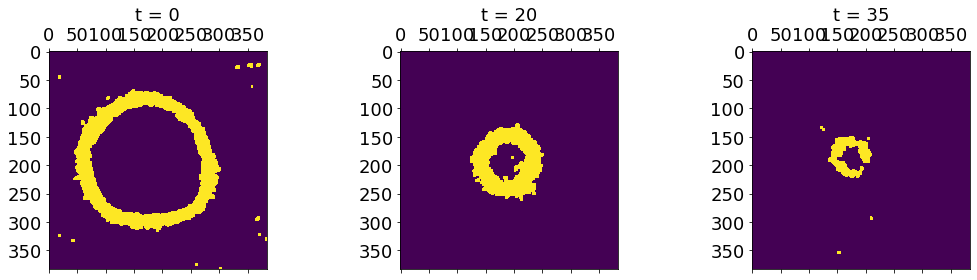

In [17]:
# Generate data images
# Size of images
im_x = 384
im_y = 384 
datax = pd.read_csv("data_wound_WT_x.csv",header = None)
datay = pd.read_csv("data_wound_WT_y.csv",header = None)

fig = plt.figure()
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=18)
# Create an axes instance
fig, axs = plt.subplots(1, 3, tight_layout=True,figsize=(15,4)) 

# Panel 1: time 0
t = 0
img = to_img(t,datax,datay)
axs[0].matshow(img)
axs[0].set_title('t = 0', size =18)

# Panel 2: time 20
t = 20
img = to_img(t,datax, datay)
axs[1].matshow(img)
axs[1].set_title('t = 20', size =18)

# Panel 3: time 35
t = 35
img = to_img(t,datax, datay)
axs[2].matshow(img)
axs[2].set_title('t = 35', size = 18)

plt.show()

In [18]:
# # If computing PH of each time frame (birth-death pairs)

# allx = datax
# ally = datay
# list_bd = calculate_all_persistence_diagrams(allx, ally)

# # Output file
# pickle_filename = 'list_bdpairs_wound_WT_new'
# with open(pickle_filename, 'wb') as h:
#    pickle.dump([list_bd],h,protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# If importing previously-computed birth-death pair calculation
pickle_filename = 'list_bdpairs_wound_WT.pkl'
with open(pickle_filename,'rb') as handle:
    list_bd = pickle.load(handle)
list_bd = list_bd[0]

#create connection matrices: l_mat, all_x_conn, all_y_conn
wass_order = 2 # Wasserstein parameter
l_mat2, all_x_conn2, all_y_conn2 = generate_connection_arrays(list_bd, wass=True, bott=False, p_order=wass_order)
path_num = determine_significant_path(l_mat2, all_x_conn2, all_y_conn2)

<Figure size 432x288 with 0 Axes>

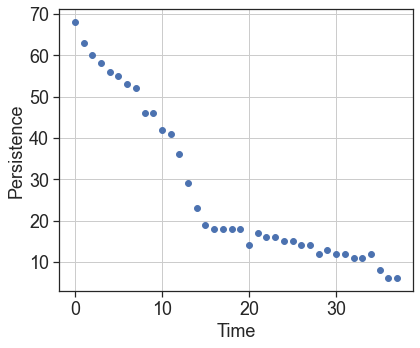

In [20]:
# Plot top path
from matplotlib import rc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn
seaborn.set(style='ticks')

fig = plt.figure() 
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=18)
# Create an axes instance
fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(6,5))

time_step = 1
all_x_conn = all_x_conn2[path_num]
all_y_conn = all_y_conn2[path_num]
all_sig_pts_dist = all_y_conn-all_x_conn
all_sig_times = [time_step*x for x in range(0,len(all_x_conn))]
axs.scatter(all_sig_times,all_sig_pts_dist, s=35)
    
axs.set_xlabel('Time',size = 18)
axs.set_ylabel('Persistence',size = 18)
axs.grid(True, which='major')
 
plt.show()